In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Initial random forest predictions

In [ ]:
hits_train = pd.read_csv("data/train.csv", index_col='global_id')
hits_test = pd.read_csv("data/test.csv", index_col='global_id')
wires = pd.read_csv("data/wires.csv", index_col='wire_id')

In [ ]:
wires_cartesian = np.vstack((wires['wire_rho'] * np.cos(wires['wire_phi']),
                                  wires['wire_rho'] * np.sin(wires['wire_phi']))).T
wires_r = np.vstack((wires['wire_rho'], wires['wire_phi'])).T

In [ ]:
from sklearn.ensemble import RandomForestClassifier

We tried another features: mean and std of energy for event, share of 15 neigbors with non-zero energy, average non-zero energy of 15 neighbors, but they didn't work for us. 

In [ ]:
features_list = ['energy_deposit', 'relative_time', 'wire_x', 'wire_y', 
                 'wire_r', 'x_plus_y', 'x_minus_y', 'xy', 'log_en', 'sq_time']

We performed an extensive manual grid search of RF parameters, and found the default ones are best, dependence of the performance on number of estimators was looking like sqrt(x), so we decided to STACK MORE ESTIMATORS. It took about 30 minutes to fit and about 18 GB of swap in addition to 4 GB RAM. We were lucky to have fast SSD drive on one of the laptops to make it possible.

In [ ]:
clf = RandomForestClassifier(n_estimators=700, criterion='gini', 
                             max_depth=None, n_jobs=-1, verbose=0, random_state=13, 
                             min_weight_fraction_leaf=0.0, class_weight=None)

In [ ]:
hits_train['wire_x'] = wires_cartesian[hits_train.wire_id][:,0]
hits_train['wire_y'] = wires_cartesian[hits_train.wire_id][:,1]
hits_train['wire_r'] = wires_r[hits_train.wire_id][:,0]
hits_train['x_plus_y'] = np.array(hits_train['wire_x'].values) + np.array(hits_train['wire_y'].values)
hits_train['x_minus_y'] = np.array(hits_train['wire_x'].values) - np.array(hits_train['wire_y'].values)
hits_train['xy'] = np.array(hits_train['wire_x'].values) * np.array(hits_train['wire_y'].values)
hits_train['log_en'] = np.log(np.array(hits_train['energy_deposit'].values)**2)
hits_train['sq_time'] = np.array(hits_train['relative_time'].values)**2

In [ ]:
hits_test['wire_x'] = wires_cartesian[hits_test.wire_id][:,0]
hits_test['wire_y'] = wires_cartesian[hits_test.wire_id][:,1]
hits_test['wire_r'] = wires_r[hits_test.wire_id][:,0]
hits_test['x_plus_y'] = np.array(hits_test['wire_x'].values) + np.array(hits_test['wire_y'].values)
hits_test['x_minus_y'] = np.array(hits_test['wire_x'].values) - np.array(hits_test['wire_y'].values)
hits_test['xy'] = np.array(hits_test['wire_x'].values) * np.array(hits_test['wire_y'].values)
hits_test['log_en'] = np.log(np.array(hits_test['energy_deposit'].values)**2)
hits_test['sq_time'] = np.array(hits_test['relative_time'].values)**2

In [ ]:
good = hits_train[hits_train.energy_deposit > 0]
clf.fit(good[features_list].values, (good.label==1).astype(int))

In [ ]:
candidates = hits_test[hits_test.energy_deposit > 0]
candidates['prediction'] = clf.predict_proba(candidates[features_list])[:,1]

###Filter predictions by the circle center +/- pi/2

It goes through each event by id, plots histogram of the predictions and finds it's maximum based on the assumption that it should be around the center of the track circle.
Overal it takes about 2-3 minutes to calculate everything.

In [ ]:
for e in np.unique(candidates.event_id):
    ev = candidates[candidates.event_id == e]
    a,b=np.histogram(wires_r[ev[ev.prediction > .5].wire_id][:,1], 
                     weights=np.array(ev[ev.prediction > .5].prediction), bins=30)
    # Find the maximum of the histogram and create bounds around it
    mn = b[np.argmax(a)+1]
    bounds = np.array([mn+(np.pi/2.),mn-(np.pi/2.)])
    bounds = [bounds-(2*np.pi), bounds, bounds+(2*np.pi)]
    # Complicated conditions, because phi lied within [0, 2pi] but there could
    # be problems at the edges of the range.
    cond = (wires_r[ev.wire_id][:,1] >= bounds[1][1])*(wires_r[ev.wire_id][:,1] <= bounds[1][0]) + \
    (wires_r[ev.wire_id][:,1] >= bounds[0][1])*(wires_r[ev.wire_id][:,1] <= bounds[0][0]) + \
    (wires_r[ev.wire_id][:,1] >= bounds[2][1])*(wires_r[ev.wire_id][:,1] <= bounds[2][0])
    # Set everything outside the bounds to 0
    candidates.loc[ev.index[-cond], 'prediction'] = np.zeros(np.sum(-cond))
    print e

In [ ]:
prs = pd.DataFrame()
prs['prediction'] = candidates.prediction
prs.index = candidates.index
prs.to_csv('rf_with_filter_700.csv', index_label='global_id')

### Filter the rest by the window around the track

In [2]:
#preds = pd.read_csv('rf_with_filter_700.csv', index_col='global_id')
preds = pd.read_csv('predictions/rf_manlike_and_filter_700.csv', index_col='global_id')

In [3]:
hits_test = pd.read_csv("data/nonzero_test_xyrphi.csv", index_col='global_id')
hits_test =  pd.concat([hits_test, preds], axis=1)
hits_test_fixed = hits_test.copy()

In [4]:
hits_test.head()

,event_id,wire_x,wire_y,wire_rho,wire_phi,prediction
global_id,,,,,,
7619403,1700,52.760012,5.037970,53,0.095200,0.000000
7619407,1700,51.697779,11.676458,53,0.222133,0.964286
7619408,1700,51.301281,13.310843,53,0.253866,0.734286
7619415,1700,47.108279,24.286006,53,0.475999,0.000000
7619422,1700,40.600355,34.067743,53,0.698132,0.000000


## Choosing event to check

In [59]:
check_id = 1700

##Checking predictions

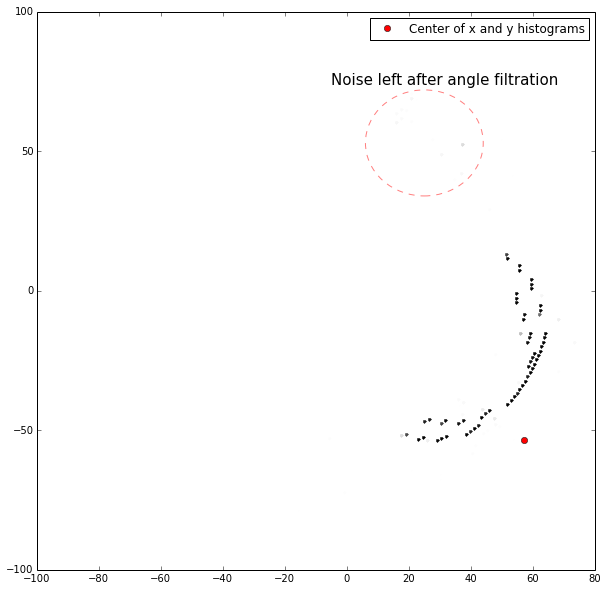

In [60]:
ev = hits_test[hits_test.event_id == check_id]

vals = np.unique(ev.prediction)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1, 1, 1)

a = np.histogram(ev.wire_x[ev.prediction > 0.5].values, bins=20)
b = np.histogram(ev.wire_y[ev.prediction > 0.5].values, bins=20)

x_mean = a[1][np.argmax(a[0])]
y_mean = b[1][np.argmax(b[0])]

for pr in vals:
    plt.plot([ev.loc[i,'wire_x'] for i in ev[ev.prediction==pr].index], 
             [ev.loc[i,'wire_y'] for i in ev[ev.prediction==pr].index], 'k.', alpha = pr)
    
circ = plt.Circle((25,53), radius=19, color='r', linestyle='dashed', alpha=0.5, fill=False)
ax.add_patch(circ)
ax.text(-5, 74, r'Noise left after angle filtration', fontsize=15)
plt.plot(x_mean, y_mean, 'ro', label='Center of x and y histograms')
plt.legend(numpoints=1)

##Performing denoise by x-y in cycle

Condition is pretty straightforward: remove all the predictions outside 160x160 square with center in the red dot. A bit of overkill, but we needed to be sure that we wouldn't kill any signal points. There also was a try to perform filtering by radius (commented below), which didn't work. 

In [35]:
for e in np.unique(hits_test.event_id):
    ev = hits_test[hits_test.event_id == e]
    a = np.histogram(ev.wire_x[ev.prediction > 0.5].values, bins=20)
    #a_weihted = np.histogram(ev.wire_x[ev.prediction > 0.5].values, bins=20, weights=ev.prediction[ev.prediction>0.5])
    x_mean = a[1][np.argmax(a[0])]
    bounds_x = np.array([x_mean-80, x_mean+80])
    cond_x = (ev.wire_x > bounds_x[0])*(ev.wire_x < bounds_x[1])
       
    b = np.histogram(ev.wire_y[ev.prediction > 0.5].values, bins= 20, normed=True)
    y_mean = b[1][np.argmax(b[0])]
    bounds_y = np.array([y_mean-80, y_mean+80])
    cond_y = (ev.wire_y > bounds_y[0])*(ev.wire_y < bounds_y[1])
    
    #there also was a try to perform filtering by radius
    #ar = np.histogram(ev_fixed.wire_rho.values, bins=40, weights=ev_fixed.prediction.values)
    #r_mean = ar[1][np.argmax(ar[0])]
    #cond_r = ev.wire_rho > r_mean+5
    
    hits_test_fixed.loc[ev.index[-cond_x], 'prediction'] = np.zeros(np.sum(-cond_x))
    hits_test_fixed.loc[ev.index[-cond_y], 'prediction'] = np.zeros(np.sum(-cond_y))
    #hits_test_fixed.loc[ev.index[-cond_r], 'prediction'] = np.zeros(np.sum(-cond_r))
    
    #print e

/usr/local/lib/python2.7/dist-packages/pandas/computation/expressions.py:184: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


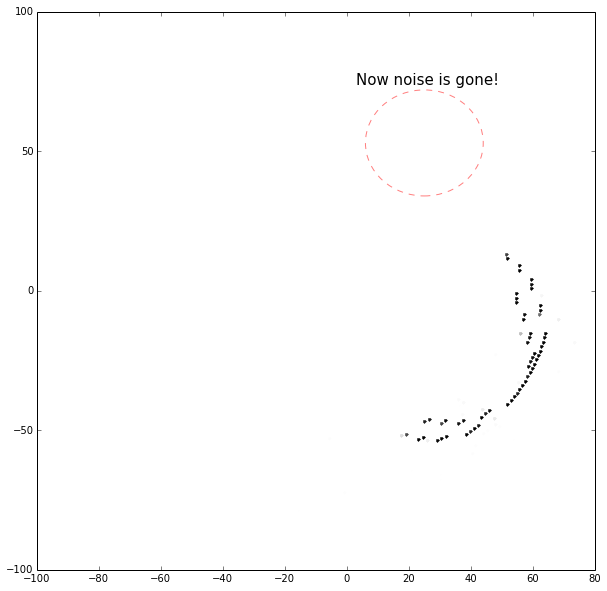

In [61]:
ev_fixed = hits_test_fixed[hits_test.event_id == check_id]
vals_fixed = np.unique(ev_fixed.prediction)
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1, 1, 1)

a = np.histogram(ev_fixed[ev_fixed.prediction > 0.5].wire_rho.values, bins=40, weights=ev_fixed[ev_fixed.prediction > 0.5].prediction.values)


maxr = a[1][np.argmax(a[0])]

for pr in vals_fixed:
    plt.plot([ev_fixed.loc[i,'wire_x'] for i in ev_fixed[ev_fixed.prediction==pr].index], 
             [ev_fixed.loc[i,'wire_y'] for i in ev_fixed[ev_fixed.prediction==pr].index], 'k.', alpha = pr)
    
circ = plt.Circle((25,53), radius=19, color='r', linestyle='dashed', alpha=0.5, fill=False)
ax.add_patch(circ)
ax.text(3, 74, r'Now noise is gone!', fontsize=15)

##Saving predictions for submit and hoping for the best.

In [ ]:
prs = pd.DataFrame()
prs['prediction'] = hits_test_fixed.prediction
prs.index = hits_test_fixed.index
prs.to_csv('rf_manlike_and_filter_700_xy_denoise.csv', index_label='global_id')

##Thank you!